In [295]:
import os
import numpy as np 
import pandas as pd
import pickle
# plotting 
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
# gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
# utils 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.utils import resample
# dataset
from dataset import Dataset
# metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from datetime import datetime

RAND_ST = 26
__notebook_path__ = os.getcwd()

def make_timestamp() -> str:
    now = datetime.now()
    return now.strftime("%m%d%Y-%H:%M")


In [308]:
def print_cv_res(model_name, res_summary_df):
    # print results of CV stored in pd.DataFrame
    print(f"{model_name}: R2={res_summary_df['r2'].mean():.3f}({res_summary_df['r2'].std():.3f}), RMSE={res_summary_df['rmse'].mean():.3f}({res_summary_df['rmse'].std():.3f}), MSE={res_summary_df['mae'].mean():.3f}({res_summary_df['mae'].std():.3f})")


# Upload data

In [303]:
#dataset_path = f'{__notebook_path__}/envs_r4_h0.005_f0.1+test'
dataset_path = f'{__notebook_path__}/envs_r4_f0.1_Hopt'

store_model_path = f'{__notebook_path__}/model'
t_threshold = 0.04 # transfer integral threshold in eV

dataset_pd = Dataset(dataset_path).items
dataset_pd = dataset_pd.sort_values('hval') # sort by the hopping value
X_total = dataset_pd.to_numpy()[:,3:].astype(float)
Y_total = dataset_pd.to_numpy()[:,1].astype(float).reshape(-1,1)
classes_total = np.array([1 if y > t_threshold else 0 for y in Y_total.flatten()])

# split dataset into parts with low and large hoppings
dataset_pd_higt = dataset_pd.loc[dataset_pd['hval'] >= t_threshold]
dataset_pd_lowt = dataset_pd.loc[dataset_pd['hval'] < t_threshold]
print(f"Total # of small hopp: {dataset_pd_lowt.shape}, large hopp: {dataset_pd_higt.shape}")

# number of dataset items with high hopping 
n_higt = dataset_pd_higt.shape[0]
# number of dataset items with low hopping 
n_lowt = dataset_pd_lowt.shape[0]
# select the same number of dataset items with low hopping as for high hopping
indices_to_select_lowt = np.random.choice(np.arange(n_lowt, dtype=int), int(n_higt)).tolist()
dataset_pd_lowt = dataset_pd_lowt.iloc[indices_to_select_lowt]

dataset_pd_concat = pd.concat([dataset_pd_lowt, dataset_pd_higt])

X_lowt = dataset_pd_lowt.to_numpy()[:,3:].astype(float)
Y_lowt = dataset_pd_lowt.to_numpy()[:,1].astype(float).reshape(-1,1)
X_hight = dataset_pd_higt.to_numpy()[:,3:].astype(float)
Y_hight = dataset_pd_higt.to_numpy()[:,1].astype(float).reshape(-1,1)

X_lowt_train, X_lowt_test, Y_lowt_train, Y_lowt_test = train_test_split(X_lowt, Y_lowt, test_size=0.2, random_state=RAND_ST)
X_hight_train, X_hight_test, Y_hight_train, Y_hight_test = train_test_split(X_hight, Y_hight, test_size=0.2, random_state=RAND_ST)

X_train = np.concatenate((X_lowt_train, X_hight_train), axis=0)
X_test = np.concatenate((X_lowt_test, X_hight_test), axis=0)
Y_train = np.concatenate((Y_lowt_train, Y_hight_train), axis=0)
Y_test = np.concatenate((Y_lowt_test, Y_hight_test), axis=0)

# get numpy entities 
X = dataset_pd_concat.to_numpy()[:,3:].astype(float)
Y = dataset_pd_concat.to_numpy()[:,1].astype(float).reshape(-1,1)
n, p = X.shape

X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.2, random_state=RAND_ST)

print(f"Total: {X_total.shape}")
print(Y_total.flatten())
print(classes_total)
print(f"# small hopp: {dataset_pd_lowt.shape}, large hopp: {dataset_pd_higt.shape}")
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(np.min(Y), np.max(Y))
print(np.min(Y_test), np.max(Y_test))

Total # of small hopp: (1331, 186), large hopp: (480, 186)
Total: (1811, 183)
[0.00429  0.00498  0.005004 ... 0.4759   0.487014 0.522831]
[0 0 0 ... 1 1 1]
# small hopp: (480, 186), large hopp: (480, 186)
(960, 183)
(1448, 183)
(363, 183)
0.005018 0.522831
0.005017 0.487014


# Neural Network

In [304]:
def plot_history(histories):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5), sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        ax.plot(histories[i].history['loss'])
        ax.set_xlabel('Epoch')
    
    last_loss = [_.history['loss'][-1] for _ in histories]
    print(last_loss)

    plt.show()

def evaluate_estimator(estimator, X_test, Y_test, X_train, Y_train, save_plot):
    y_pred = estimator.predict(X_test)
    Y_pred = y_pred.mean(axis=1)

    Y_pred_train = estimator.predict(X_train).mean(axis=1)

    # calculate metrics 
    rmse_test = mean_squared_error(Y_test, Y_pred, squared=False)
    mae_test  = mean_absolute_error(Y_test, Y_pred)
    r2_test   = r2_score(Y_test, Y_pred)

    rmse_train = mean_squared_error(Y_train, Y_pred_train, squared=False)
    mae_train  = mean_absolute_error(Y_train, Y_pred_train)
    r2_train   = r2_score(Y_train, Y_pred_train)

    fig, ax  = plt.subplots(1, 1)
    # plot
    ax.scatter(Y_train, Y_pred_train, label='Train')
    ax.scatter(Y_test, Y_pred, label='Test')
    ax.plot([-0.05, 1], [-0.05, 1], '--r')
    ax.set_xlim([-0.05, 0.6])
    ax.set_ylim([-0.05, 0.6])
    ax.set_xlabel('Calculated t_{ij}, eV')
    ax.set_ylabel('Predicted t_{ij}, eV')
    ax.legend()
    ax.set_title(f'Test: R2={r2_test:.3f}, RMSE={rmse_test:.3f}, MAE={mae_test:.3f}\nTrain: R2={r2_train:.3f}, RMSE={rmse_train:.3f}, MAE={mae_train:.3f}')
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')

    timestamp = make_timestamp()
    if save_plot:
        np.savetxt(
            f"eval_results/random_split_100_estimators_{timestamp}_test.csv", 
            np.column_stack((
                            Y_test, 
                            Y_pred, 
                            )),
            header="Y_test,Y_test_pred",
            delimiter=','
        )
        np.savetxt(
            f"eval_results/random_split_100_estimators_{timestamp}_train.csv", 
            np.column_stack((
                            Y_train, 
                            Y_pred_train, 
                            )),
            header="Y_train,Y_train_pred",
            delimiter=','
        )

    plt.show()
    

In [246]:
KFOLDS = 6
DROPOUT_RATE = 0.05
LEARN_RATE = 0.001
NUM_FEATURES = 183

In [247]:
def apply_bn_and_dropout(x):
    return layers.Dropout(DROPOUT_RATE)(layers.BatchNormalization()(x))

In [305]:
def make_ann():
    # ANN for prediction of hooping
    input = keras.Input(shape=(NUM_FEATURES,))
    x = layers.Dense(128, activation='relu')(input)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(64, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(32, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(16, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    out = layers.Dense(1, name="affinity")(x)
    ann = keras.Model(input, out, name="t_predictor")
    ann.summary()
    return ann


In [306]:
class EnsembleANN:
    def __init__(self, X, Y, n_estimators=100):
        self.n_estimators = n_estimators
        self.X = X
        self.Y = Y
        self.models = []
        self.histories = []
        self.scalersX = []
    
    def train_ensamble(self):
        for _ in range(self.n_estimators):
            train_ix = resample(list(range(len(self.X))))
            X_train, Y_train = self.X[train_ix], self.Y[train_ix]

            scaler_X = MinMaxScaler().fit(X_train)
            #X_train = scaler_X.transform(X_train)
            self.scalersX.append(scaler_X)

            t_ann = make_ann()
            t_ann.compile(
                optimizer=keras.optimizers.legacy.Adam(LEARN_RATE), 
                loss=keras.losses.MeanSquaredError())
            t_hist = t_ann.fit(
                X_train, 
                Y_train, 
                epochs=2000, 
                batch_size=256,
                verbose=0
            ) 
            
            self.models.append(t_ann)
            self.histories.append(t_hist)
    
    def predict(self, X):
        n = X.shape[0]
        models_pred = np.zeros((n, self.n_estimators))
        
        for i, model in enumerate(self.models):
            #X = self.scalersX[i].transform(X)
            y_pred = np.abs(model.predict(X))
            models_pred[:, i] = y_pred[:, 0]
        
        return models_pred
    
    def save_estimators(self, path_to_save):
        for i, model in enumerate(self.models):
            model.save(f'{path_to_save}/{i}.keras')

    def load_estimators(self, path_to_load):
        if len(self.models) == 0:
            for i in range(self.n_estimators):
                # load model 
                t_model = keras.models.load_model(f'{path_to_load}/{i}.keras')
                self.models.append(t_model)
        else:
            print('Estimators are trained.')


In [271]:
print(X_train.shape, X_test.shape)

(1448, 183) (363, 183)


In [307]:
meta_ann = EnsembleANN(X_train, Y_train, n_estimators=150)
meta_ann.train_ensamble()

Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_458 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1834 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1834 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1834 (Dropout)      (None, 128)               0         
                                                                 
 dense_1835 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1835 (B  (None, 64)               256       
 atchNormalization)                                    

[0.00012999973841942847, 0.000179871276486665, 0.0001786702050594613, 0.0001673116348683834, 0.00019125317339785397, 0.0002204480697400868, 0.0001504175888840109, 0.00031601989758200943, 0.00016078965563792735, 0.00019289842748548836, 0.0001708155032247305, 0.0002513764484319836, 0.00016049767145887017, 0.0001506590924691409, 0.00016248042811639607, 0.00012695432815235108, 0.0002103758743032813, 0.000127855921164155, 0.00014222647587303072, 0.0001658905966905877, 0.00015787180745974183, 0.00016216754738707095, 0.0002498032699804753, 0.00017778482288122177, 0.00014333905710373074, 0.0001993505284190178, 0.00022886510123498738, 0.0001156286962213926, 0.0002800897927954793, 0.00014624500181525946, 0.00019260005501564592, 0.00016669659817125648, 0.0001302977034356445, 0.00022473091667052358, 0.00014075507351662964, 0.00016994320321828127, 0.00015358785458374768, 0.00016851391410455108, 0.0002318879123777151, 0.00016066331590991467, 0.00021313002798706293, 0.0001678347762208432, 0.000135160

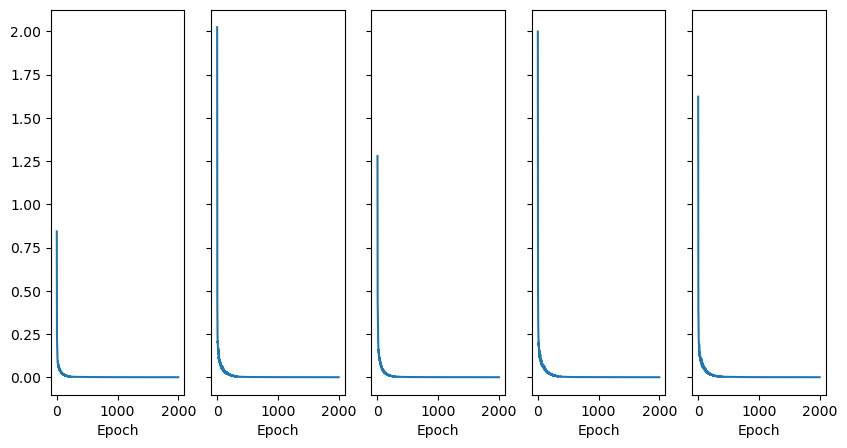

In [300]:
plot_history(meta_ann.histories)

46/46 [==============================] - 0s 505us/step


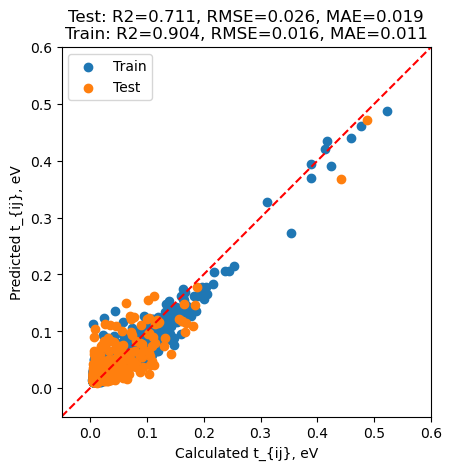

In [309]:
evaluate_estimator(meta_ann, X_test, Y_test, X_train, Y_train, save_plot=False)

In [ ]:
# save estimators
path_to_save = 'model/estimators/'
meta_ann.save_estimators(path_to_save)

In [ ]:
# load estimators
meta_ann_load = EnsembleANN(X_train, Y_train, n_estimators=25)
meta_ann_load.load_estimators(path_to_save)

print(len(meta_ann_load.models))

In [ ]:
evaluate_estimator(meta_ann_load, X_test, Y_test, X_train, Y_train)

# Cross-Validation

## Stratified KFOLD

In [269]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, 0],
        xlim=[-0.5, len(X) - 0.5],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

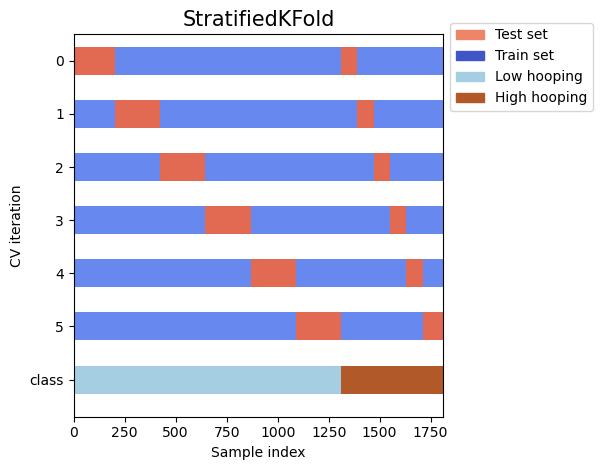

In [270]:
fig, ax = plt.subplots()
plot_cv_indices(StratifiedKFold(n_splits=6, shuffle=False), X_total, classes_total, ax, 6)
ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02)), Patch(color=cmap_data(0)), Patch(color=cmap_data(11))],
        ["Test set", "Train set", "Low hooping", "High hooping"],
        loc=(1.02, 0.8),
)
plt.tight_layout()
fig.subplots_adjust(right=0.7)

In [261]:
res_skf_lir = {'r2': [], 'rmse': [], 'mae': []}
res_skf_rfr = {'r2': [], 'rmse': [], 'mae': []}
res_skf_gpr = {'r2': [], 'rmse': [], 'mae': []}
res_skf_ann = {'r2': [], 'rmse': [], 'mae': []}
res_skf_ann_en = {'r2': [], 'rmse': [], 'mae': []}

skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True)

for i, (train_index, test_index) in enumerate(skf.split(X_total, classes_total)):
    X_skf_train, Y_skf_train = X_total[train_index], Y_total[train_index]
    X_skf_test, Y_skf_test = X_total[test_index], Y_total[test_index]

    # LINEAR REGRESSION
    lir = LinearRegression().fit(X_skf_train, Y_skf_train)
    Y_lir = np.abs(lir.predict(X_skf_test))
    res_skf_lir['r2'].append(r2_score(Y_skf_test, Y_lir))
    res_skf_lir['rmse'].append(mean_squared_error(Y_skf_test, Y_lir, squared=False))
    res_skf_lir['mae'].append(mean_absolute_error(Y_skf_test, Y_lir))

    # RANDOM FOREST 
    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=100, 
        max_features='sqrt',
        random_state=RAND_ST
    ).fit(X_skf_train, Y_skf_train.ravel())
    Y_rfr = np.abs(rfr.predict(X_skf_test))
    res_skf_rfr['r2'].append(r2_score(Y_skf_test, Y_rfr))
    res_skf_rfr['rmse'].append(mean_squared_error(Y_skf_test, Y_rfr, squared=False))
    res_skf_rfr['mae'].append(mean_absolute_error(Y_skf_test, Y_rfr))

    # GAUSSIAN PROCESS REGRESSION
    # kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * NUM_FEATURES, length_scale_bounds=(1e-36, 1e36), nu=2.0)
    # gpr = GaussianProcessRegressor(
    #     kernel=kernel,
    #     alpha=0.005, 
    #     n_restarts_optimizer=500,
    #     random_state=RAND_ST
    # ).fit(X_train, Y_train)
    # Y_gpr = gpr.predict(X_test)
    # res_skf_gpr['r2'].append(r2_score(Y_test, Y_gpr))
    # res_skf_gpr['rmse'].append(mean_squared_error(Y_test, Y_gpr, squared=False))
    # res_skf_gpr['mae'].append(mean_absolute_error(Y_test, Y_gpr))

    # ARTIFICIAL NEURAL NETWORK 
    ann = make_ann()
    ann.compile(
        optimizer=keras.optimizers.legacy.Adam(LEARN_RATE), 
        loss=keras.losses.MeanSquaredError())
    ann.fit(
        X_skf_train, 
        Y_skf_train, 
        epochs=2000, 
        batch_size=256,
        verbose=0
    ) 
    Y_ann = np.abs(ann.predict(X_skf_test))
    res_skf_ann['r2'].append(r2_score(Y_skf_test, Y_ann))
    res_skf_ann['rmse'].append(mean_squared_error(Y_skf_test, Y_ann, squared=False))
    res_skf_ann['mae'].append(mean_absolute_error(Y_skf_test, Y_ann))

    # ENSEMBLE ARTIFICIAL NEURAL NETWORK
    # ann_en = EnsembleANN(X_train, Y_train, n_estimators=100)
    # ann_en.train_ensamble()
    # Y_ann_en = ann_en.predict(X_test)
    # res_ann_en['r2'].append(r2_score(Y_test, Y_ann_en))
    # res_ann_en['rmse'].append(mean_squared_error(Y_test, Y_ann_en, squared=False))
    # res_ann_en['mae'].append(mean_absolute_error(Y_test, Y_ann_en))
    
    print(f'Completed fold: {i}')

Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_302 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1210 (Dense)          (None, 256)               47104     
                                                                 
 batch_normalization_1210 (B  (None, 256)              1024      
 atchNormalization)                                              
                                                                 
 dropout_1210 (Dropout)      (None, 256)               0         
                                                                 
 dense_1211 (Dense)          (None, 128)               32896     
                                                                 
 batch_normalization_1211 (B  (None, 128)              512       
 atchNormalization)                                    

In [262]:
res_lir_skf_df = pd.DataFrame(data=res_skf_lir)
res_rfr_skf_df = pd.DataFrame(data=res_skf_rfr)
res_gpr_skf_df = pd.DataFrame(data=res_skf_gpr)
res_ann_skf_df = pd.DataFrame(data=res_skf_ann)
res_ann_skf_en_pd = pd.DataFrame(data=res_skf_ann_en)

In [277]:
res_rfr_skf_df

,r2,rmse,mae
0,0.607523,0.032870,0.021212
1,0.555498,0.035255,0.019935
2,0.562865,0.034666,0.021488
3,0.593597,0.032195,0.019423
4,0.498597,0.025920,0.018390
5,0.565145,0.036011,0.021873


In [263]:
print("STRATIFIED KFOLD")
print(f"LIR: R2={res_lir_skf_df['r2'].mean():.3f}({res_lir_skf_df['r2'].std():.3f}), RMSE={res_lir_skf_df['rmse'].mean():.3f}({res_lir_skf_df['rmse'].std():.3f}), MSE={res_lir_skf_df['mae'].mean():.3f}({res_lir_skf_df['mae'].std():.3f})")
print(f"RFR: R2={res_rfr_skf_df['r2'].mean():.3f}({res_rfr_skf_df['r2'].std():.3f}), RMSE={res_rfr_skf_df['rmse'].mean():.3f}({res_rfr_skf_df['rmse'].std():.3f}), MSE={res_rfr_skf_df['mae'].mean():.3f}({res_rfr_skf_df['mae'].std():.3f})")
print(f"GPR: R2={res_gpr_skf_df['r2'].mean():.3f}({res_gpr_skf_df['r2'].std():.3f}), RMSE={res_gpr_skf_df['rmse'].mean():.3f}({res_gpr_skf_df['rmse'].std():.3f}), MSE={res_gpr_skf_df['mae'].mean():.3f}({res_gpr_skf_df['mae'].std():.3f})")
print(f"ANN: R2={res_ann_skf_df['r2'].mean():.3f}({res_ann_skf_df['r2'].std():.3f}), RMSE={res_ann_skf_df['rmse'].mean():.3f}({res_ann_skf_df['rmse'].std():.3f}), MSE={res_ann_skf_df['mae'].mean():.3f}({res_ann_skf_df['mae'].std():.3f})")

STRATIFIED KFOLD
LIR: R2=0.373(0.112), RMSE=0.039(0.003), MSE=0.027(0.001)
RFR: R2=0.564(0.038), RMSE=0.033(0.004), MSE=0.020(0.001)
GPR: R2=nan(nan), RMSE=nan(nan), MSE=nan(nan)
ANN: R2=0.285(0.551), RMSE=0.040(0.016), MSE=0.028(0.016)


## KFOLD

In [289]:
res_lir = {'r2': [], 'rmse': [], 'mae': []}
res_rfr = {'r2': [], 'rmse': [], 'mae': []}
res_gpr = {'r2': [], 'rmse': [], 'mae': []}
res_ann = {'r2': [], 'rmse': [], 'mae': []}
res_ann_en = {'r2': [], 'rmse': [], 'mae': []}

kf = KFold(n_splits=KFOLDS, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X_total)):
    X_train, Y_train = X_total[train_index], Y_total[train_index]
    X_test, Y_test = X_total[test_index], Y_total[test_index]

    # LINEAR REGRESSION
    lir = LinearRegression().fit(X_train, Y_train)
    Y_lir = lir.predict(X_test)
    res_lir['r2'].append(r2_score(Y_test, Y_lir))
    res_lir['rmse'].append(mean_squared_error(Y_test, Y_lir, squared=False))
    res_lir['mae'].append(mean_absolute_error(Y_test, Y_lir))

    # RANDOM FOREST 
    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=1, 
        max_features='sqrt',
        random_state=RAND_ST
    ).fit(X_train, Y_train.ravel())
    Y_rfr = rfr.predict(X_test)
    res_rfr['r2'].append(r2_score(Y_test, Y_rfr))
    res_rfr['rmse'].append(mean_squared_error(Y_test, Y_rfr, squared=False))
    res_rfr['mae'].append(mean_absolute_error(Y_test, Y_rfr))

    # GAUSSIAN PROCESS REGRESSION
    # kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * NUM_FEATURES, length_scale_bounds=(1e-36, 1e36), nu=2.0)
    # gpr = GaussianProcessRegressor(
    #     kernel=kernel,
    #     alpha=0.005, 
    #     n_restarts_optimizer=500,
    #     random_state=RAND_ST
    # ).fit(X_train, Y_train)
    # Y_gpr = gpr.predict(X_test)
    # res_gpr['r2'].append(r2_score(Y_test, Y_gpr))
    # res_gpr['rmse'].append(mean_squared_error(Y_test, Y_gpr, squared=False))
    # res_gpr['mae'].append(mean_absolute_error(Y_test, Y_gpr))

    # ARTIFICIAL NEURAL NETWORK 
    ann = make_ann()
    ann.compile(
        optimizer=keras.optimizers.legacy.Adam(LEARN_RATE), 
        loss=keras.losses.MeanSquaredError())
    ann.fit(
        X_train, 
        Y_train, 
        epochs=2000, 
        batch_size=256,
        verbose=0
    ) 
    Y_ann = ann.predict(X_test)
    res_ann['r2'].append(r2_score(Y_test, Y_ann))
    res_ann['rmse'].append(mean_squared_error(Y_test, Y_ann, squared=False))
    res_ann['mae'].append(mean_absolute_error(Y_test, Y_ann))

    # ENSEMBLE ARTIFICIAL NEURAL NETWORK
    # ann_en = EnsembleANN(X_train, Y_train, n_estimators=100)
    # ann_en.train_ensamble()
    # Y_ann_en = ann_en.predict(X_test)
    # res_ann_en['r2'].append(r2_score(Y_test, Y_ann_en))
    # res_ann_en['rmse'].append(mean_squared_error(Y_test, Y_ann_en, squared=False))
    # res_ann_en['mae'].append(mean_absolute_error(Y_test, Y_ann_en))

    print(f'Completed fold: {i}')
    

Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_347 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1390 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1390 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1390 (Dropout)      (None, 128)               0         
                                                                 
 dense_1391 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1391 (B  (None, 64)               256       
 atchNormalization)                                    

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10/10 [==============================] - 0s 691us/step
Completed fold: 0
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_348 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1394 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1394 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1394 (Dropout)      (None, 128)               0         
                                                                 
 dense_1395 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1395 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10/10 [==============================] - 0s 583us/step
Completed fold: 1
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_349 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1398 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1398 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1398 (Dropout)      (None, 128)               0         
                                                                 
 dense_1399 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1399 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10/10 [==============================] - 0s 535us/step
Completed fold: 2
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_350 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1402 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1402 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1402 (Dropout)      (None, 128)               0         
                                                                 
 dense_1403 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1403 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10/10 [==============================] - 0s 773us/step
Completed fold: 3
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_351 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1406 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1406 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1406 (Dropout)      (None, 128)               0         
                                                                 
 dense_1407 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1407 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10/10 [==============================] - 0s 640us/step
Completed fold: 4
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_352 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1410 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1410 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1410 (Dropout)      (None, 128)               0         
                                                                 
 dense_1411 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1411 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10/10 [==============================] - 0s 629us/step
Completed fold: 5


In [313]:
res_lir_df = pd.DataFrame(data=res_lir)
res_rfr_df = pd.DataFrame(data=res_rfr)
res_gpr_df = pd.DataFrame(data=res_gpr)
res_ann_df = pd.DataFrame(data=res_ann)
res_ann_en_df = pd.DataFrame(data=res_ann_en)

In [314]:
print_cv_res('LIR', res_lir_df)
print_cv_res('RFR', res_rfr_df)
print_cv_res('GPR', res_gpr_df)
print_cv_res('ANN', res_ann_df)

LIR: R2=-0.553(2.247), RMSE=0.050(0.023), MSE=0.030(0.002)
RFR: R2=0.018(0.346), RMSE=0.048(0.005), MSE=0.027(0.002)
GPR: R2=nan(nan), RMSE=nan(nan), MSE=nan(nan)
ANN: R2=0.217(0.945), RMSE=0.038(0.013), MSE=0.023(0.004)


In [ ]:
print_cv_res('ENSEMBLE ANN', res_ann_en_df)

In [404]:
# save results of cross-validation
res_lir_df.to_csv('eval_results/lir_6fold_cv.csv')
res_rfr_df.to_csv('eval_results/rfr_6fold_cv.csv')
res_gpr_df.to_csv('eval_results/gpr_6fold_cv.csv')
res_ann_df.to_csv('eval_results/ann_6fold_cv.csv')

## Shuffle-Split CV

In [296]:
res_lir_ss = {'r2': [], 'rmse': [], 'mae': []}
res_rfr_ss = {'r2': [], 'rmse': [], 'mae': []}
res_gpr_ss = {'r2': [], 'rmse': [], 'mae': []}
res_ann_ss  = {'r2': [], 'rmse': [], 'mae': []}
res_ann_en_ss = {'r2': [], 'rmse': [], 'mae': []}

ss = ShuffleSplit(n_splits=KFOLDS, test_size=0.2, random_state=RAND_ST)

for i, (train_index, test_index) in enumerate(ss.split(X_total)):
    X_train, Y_train = X_total[train_index], Y_total[train_index]
    X_test, Y_test = X_total[test_index], Y_total[test_index]

    X_train, Y_train = X_total[train_index], Y_total[train_index]
    X_test, Y_test = X_total[test_index], Y_total[test_index]

    # LINEAR REGRESSION
    lir = LinearRegression().fit(X_train, Y_train)
    Y_lir_ss = lir.predict(X_test)
    res_lir_ss['r2'].append(r2_score(Y_test, Y_lir_ss))
    res_lir_ss['rmse'].append(mean_squared_error(Y_test, Y_lir_ss, squared=False))
    res_lir_ss['mae'].append(mean_absolute_error(Y_test, Y_lir_ss))

    # RANDOM FOREST 
    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=1, 
        max_features='sqrt',
        random_state=RAND_ST
    ).fit(X_train, Y_train.ravel())
    Y_rfr_ss = rfr.predict(X_test)
    res_rfr_ss['r2'].append(r2_score(Y_test, Y_rfr_ss))
    res_rfr_ss['rmse'].append(mean_squared_error(Y_test, Y_rfr_ss, squared=False))
    res_rfr_ss['mae'].append(mean_absolute_error(Y_test, Y_rfr_ss))

    # GAUSSIAN PROCESS REGRESSION
    # kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * NUM_FEATURES, length_scale_bounds=(1e-36, 1e36), nu=2.0)
    # gpr = GaussianProcessRegressor(
    #     kernel=kernel,
    #     alpha=0.005, 
    #     n_restarts_optimizer=500,
    #     random_state=RAND_ST
    # ).fit(X_train, Y_train)
    # Y_gpr = gpr.predict(X_test)
    # res_gpr['r2'].append(r2_score(Y_test, Y_gpr))
    # res_gpr['rmse'].append(mean_squared_error(Y_test, Y_gpr, squared=False))
    # res_gpr['mae'].append(mean_absolute_error(Y_test, Y_gpr))

    # ARTIFICIAL NEURAL NETWORK 
    ann = make_ann()
    ann.compile(
        optimizer=keras.optimizers.legacy.Adam(LEARN_RATE), 
        loss=keras.losses.MeanSquaredError())
    ann.fit(
        X_train, 
        Y_train, 
        epochs=2000, 
        batch_size=256,
        verbose=0
    ) 
    Y_ann_ss = ann.predict(X_test)
    res_ann_ss['r2'].append(r2_score(Y_test, Y_ann_ss))
    res_ann_ss['rmse'].append(mean_squared_error(Y_test, Y_ann_ss, squared=False))
    res_ann_ss['mae'].append(mean_absolute_error(Y_test, Y_ann_ss))

    # ENSEMBLE ARTIFICIAL NEURAL NETWORK
    # ann_en = EnsembleANN(X_train, Y_train, n_estimators=100)
    # ann_en.train_ensamble()
    # Y_ann_en = ann_en.predict(X_test)
    # res_ann_en['r2'].append(r2_score(Y_test, Y_ann_en))
    # res_ann_en['rmse'].append(mean_squared_error(Y_test, Y_ann_en, squared=False))
    # res_ann_en['mae'].append(mean_absolute_error(Y_test, Y_ann_en))

    print(f'Completed fold: {i}')

    

Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_353 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1414 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1414 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1414 (Dropout)      (None, 128)               0         
                                                                 
 dense_1415 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1415 (B  (None, 64)               256       
 atchNormalization)                                    

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12/12 [==============================] - 0s 571us/step
Completed fold: 0
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_354 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1418 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1418 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1418 (Dropout)      (None, 128)               0         
                                                                 
 dense_1419 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1419 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12/12 [==============================] - 0s 550us/step
Completed fold: 1
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_355 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1422 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1422 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1422 (Dropout)      (None, 128)               0         
                                                                 
 dense_1423 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1423 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12/12 [==============================] - 0s 539us/step
Completed fold: 2
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_356 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1426 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1426 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1426 (Dropout)      (None, 128)               0         
                                                                 
 dense_1427 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1427 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12/12 [==============================] - 0s 519us/step
Completed fold: 3
Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_357 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_1430 (Dense)          (None, 128)               23552     
                                                                 
 batch_normalization_1430 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_1430 (Dropout)      (None, 128)               0         
                                                                 
 dense_1431 (Dense)          (None, 64)                8256      
                                                                 
 batch_normalization_1431 (B  (None, 64)        

/Users/denyskononenko/opt/miniconda3/envs/ml-vis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


12/12 [==============================] - 0s 539us/step
Completed fold: 4


In [297]:
res_lir_df_ss = pd.DataFrame(data=res_lir_ss)
res_rfr_df_ss = pd.DataFrame(data=res_rfr_ss)
res_gpr_df_ss = pd.DataFrame(data=res_gpr_ss)
res_ann_df_ss = pd.DataFrame(data=res_ann_ss)
res_ann_en_df_ss = pd.DataFrame(data=res_ann_en_ss)

In [311]:
print_cv_res('LIR', res_lir_df_ss)
print_cv_res('RFR', res_rfr_df_ss)
print_cv_res('GPR', res_gpr_df_ss)
print_cv_res('ANN', res_ann_df_ss)

LIR: R2=0.317(0.031), RMSE=0.041(0.003), MSE=0.029(0.001)
RFR: R2=-0.058(0.377), RMSE=0.051(0.011), MSE=0.028(0.003)
GPR: R2=nan(nan), RMSE=nan(nan), MSE=nan(nan)
ANN: R2=0.600(0.036), RMSE=0.032(0.002), MSE=0.020(0.001)


In [ ]:
# save results of cross-validation
res_lir_df_ss.to_csv(f'eval_results/lir_ss_cv_{KFOLDS}_splits.csv')
res_rfr_df_ss.to_csv(f'eval_results/rfr_ss_cv_{KFOLDS}_splits.csv')
res_gpr_df_ss.to_csv(f'eval_results/gpr_ss_cv_{KFOLDS}_splits.csv')
res_ann_df_ss.to_csv(f'eval_results/ann_ss_cv_{KFOLDS}_splits.csv')

# Evaluation of GPR 

In [ ]:
def plot_model_eval(Y_test, Y_pred, Y_pred_std=None):
    # metrics
    rmse = mean_squared_error(Y_pred, Y_test, squared=False)
    mae  = mean_absolute_error(Y_pred, Y_test)
    r2   = r2_score(Y_pred, Y_test)
    
    fig, ax = plt.subplots(figsize=(6, 6)) 

    plt.plot(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1), color='red')

    if type(Y_pred_std) == np.ndarray:
        plt.errorbar(Y_test.flatten(), Y_pred.flatten(), Y_pred_std.flatten(), capsize=10, marker='o', ls='none')
    else:
        plt.scatter(Y_test.flatten(), Y_pred.flatten())
       
        
    plt.xlim([-0.05, 0.6])
    plt.ylim([-0.05, 0.6])
    plt.xlabel('Target')
    plt.ylabel('Prediction')
    plt.title(f'R2={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}')
    plt.show()

def validate_model(X_train, X_test, Y_train, Y_test, nu=2.0, show_plot=True, save_plot=False):
    """
    Perform validation of the GPR model.
    """
    # scale data
    scaler_X = MinMaxScaler().fit(X_train)
    scaler_Y = MinMaxScaler().fit(Y_train)
    X_train, X_test = scaler_X.transform(X_train), scaler_X.transform(X_test)
    Y_train, Y_test = scaler_Y.transform(Y_train), scaler_Y.transform(Y_test)
    
    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=300, 
        max_features='sqrt',
        random_state=RAND_ST
        )
    # select features 
    feat_selector = SelectFromModel(rfr, threshold=0.005).fit(X_train, Y_train.flatten())
    X_train_new = feat_selector.transform(X_train)
    X_test_new  = feat_selector.transform(X_test)

    print(f'{X_train_new.shape}')

    n, p = X_train_new.shape

    kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * p, length_scale_bounds=(1e-36, 1e36), nu=nu)
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.005, 
        n_restarts_optimizer=500,
        random_state=RAND_ST
        )

    # fit model and evaluate on test data 
    model.fit(X_train_new, Y_train.ravel())
    
    Y_pred, Y_std = model.predict(X_test_new, return_std=True)
    Y_pred_train, Y_train_std = model.predict(X_train_new, return_std=True)
   
    # rescale target to initial range  
    Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))
    Y_pred = np.abs(scaler_Y.inverse_transform(Y_pred.reshape(-1, 1)))
    Y_train = scaler_Y.inverse_transform(Y_train.reshape(-1, 1))
    Y_pred_train = np.abs(scaler_Y.inverse_transform(Y_pred_train.reshape(-1, 1)))

    if show_plot:
        plot_model_eval(Y_test, Y_pred)
        plot_model_eval(Y_train, Y_pred_train)
    
    # compute metrics 
    rmse = mean_squared_error(Y_pred, Y_test, squared=False)
    mae  = mean_absolute_error(Y_pred, Y_test)
    r2   = r2_score(Y_pred, Y_test)

    print(f'Number of selected features: {p}: number of points: {len(X_train)} train, {len(X_test)} test')
    print(f'rmse: {rmse} eV, mae: {mae} eV, R2: {r2}')

    # export results 
    if save_plot:
        time = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        np.savetxt(
            f"{__notebook_path__}/eval_results/test_std_{time}.dat", 
            np.column_stack((Y_test.flatten(), Y_pred.flatten(), Y_std.flatten())), 
            header='Ytrue Ypred')

        np.savetxt(
            f"{__notebook_path__}/eval_results/train_std_{time}.dat", 
            np.column_stack((Y_train.flatten(), Y_pred_train.flatten(), Y_train_std.flatten())),
            header='Ytrue Ypred'
            )

    return {'rmse': rmse, 'mae': mae, 'r2': r2}

def save_gpr(X, Y, path):
    """
    Save ML pipeline with Gaussian Process Regression for production.
    """
    scaler_X = MinMaxScaler().fit(X)
    scaler_Y = MinMaxScaler().fit(Y)
    X = scaler_X.transform(X)
    Y = scaler_Y.transform(Y)
    # export scalers
    pickle.dump(scaler_X, open(f'{path}/scalerX.sav', 'wb'))
    pickle.dump(scaler_Y, open(f'{path}/scalerY.sav', 'wb'))

    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=300, 
        max_features='sqrt',
        random_state=RAND_ST
        )
    # select features 
    feat_selector = SelectFromModel(rfr, threshold=0.005).fit(X, Y.flatten())
    X_new = feat_selector.transform(X)
    # export feature selector
    pickle.dump(feat_selector, open(f'{path}/feat_selector.sav', 'wb'))

    n, p = X_new.shape
    
    # build predictive model
    kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * p, length_scale_bounds=(1e-36, 1e36), nu=2.0)
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.0005, 
        n_restarts_optimizer=500,
        random_state=RAND_ST
        )

    print("Fit the model")
    model.fit(X_new, Y.ravel())

    print("Exporting the model")
    # export model 
    pickle.dump(model, open(f'{path}/model.sav', 'wb'))

def load_ml(file_scalerX, file_scalerY, file_feat_selector, file_model):
    scaler_X = pickle.load(open(file_scalerX, 'rb'))
    scaler_Y = pickle.load(open(file_scalerY, 'rb'))
    feat_selector = pickle.load(open(file_feat_selector, 'rb'))
    loaded_model = pickle.load(open(file_model, 'rb'))
    return scaler_X, scaler_Y, feat_selector, loaded_model



In [ ]:
validate_model(X_train, X_test, Y_train, Y_test, nu=2.0, save_plot=False)

In [ ]:
save_gpr(X_train, Y_train, store_model_path)
